#### 背景说明
最近几年,随着我国环境保护活动的开展,各种鸟类也陆续重现人们眼前,但鸟类的增多也给通信线路带来不小的威胁。部分鸟类会活动会损害通信设施，比如在信号上筑巢，啄击电缆线路，这些现象都会增大线路抢修和维护的难度。因此，使用怎样的方式确保通信设施不被鸟类损害是要重点探讨的课题。</br>
部分鸟类，比如喜鹊、乌鸦等鸟类对通信设施的威胁较大，要对其重点关注；而麻雀、燕子等鸟类的危害较小，几乎可以不做考虑。利用图像分类技术可以实时监控通信设施周围鸟类的分布情况，为保护通信设施提供有效帮助。

#### 示例数据
本项目选取5种鸟类的图片，图片分别存在在birds文件夹下的5个子文件夹中。

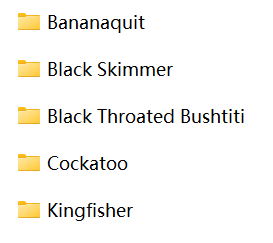

#### 分析思路
卷积神经网络提取图像特征时有较好的平移不变性，因此经常被用于图像分类。ResNet50在卷积中加入残差，解决了深层网络中梯度弥散和精度下降的问题，可以更好地保证精度。<br>
1.数据准备。读取鸟类图像，设置训练集和测试集。<br>
2.搭建神经网络。微调ResNet50网络，更改其输出为5分类。<br>
3.训练神经网络。训练搭建好的神经网络，可视化模型准确率和损失。<br>
4.验证集预测。用训练好的模型对验证集进行预测并绘图展示。
5.应用于陌生数据。用训练好的模型应用于陌生的数据集，检验模型性能。


In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

2023-02-21 11:31:48.814077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 11:31:48.814103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# 文件路径
data_dir = './birds/'

glob读取图片路径

In [3]:
# 查看图片总数
import glob
# 使用glob读取文件下的所有图片路径，计算图片个数
image_amount = len(glob.glob(data_dir+"/*/*.jpg"))
print("图片总数：",image_amount)

图片总数： 684


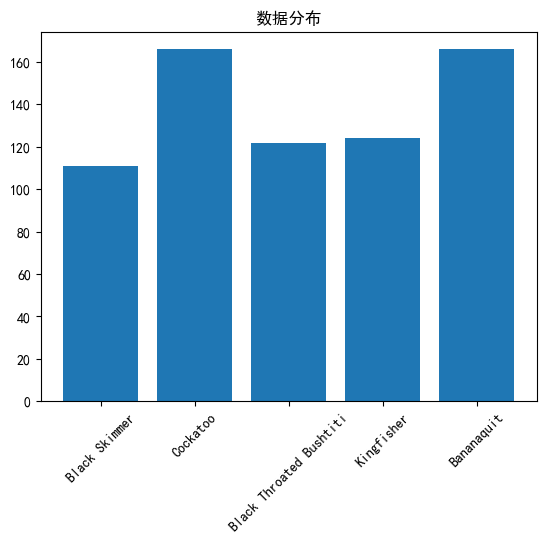

In [4]:
# 查看各类别图片数量
names = []
num = []
# 遍历路径
for dirs in os.listdir(data_dir):
    files = data_dir + "/" + dirs
    # 读取文件夹名字，即类别名称，插入names
    names = np.append(names,str(dirs))
    # 读取文件，计算图片个数，插入num
    num = np.append(num,len(os.listdir(files)))
# 绘制柱状图
plt.bar(names,num)
# 设置x轴标签倾斜45度
plt.xticks(rotation=45)
# 设置图片标题
plt.title('数据分布') 
plt.show()

In [5]:
# 打印输出类别名称
print(names)

['Black Skimmer' 'Cockatoo' 'Black Throated Bushtiti' 'Kingfisher'
 'Bananaquit']


设置训练集和验证集，验证集比例<br>
标签选择

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
# 制作训练集
train_dir = image_dataset_from_directory(
    data_dir, # 路径
    validation_split=0.2, # 验证集20%
    subset="training", # 设置为训练集
    seed=123, # 随机种子
    label_mode='categorical', # 标签编码设置为one-hot格式，多分类(多分类向量)
    image_size=(224, 224), # 图像大小设置为224*224
    batch_size=15)

Found 684 files belonging to 5 classes.
Using 548 files for training.


2023-02-21 11:31:51.833309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-21 11:31:51.833339: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 11:31:51.833356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iZ8vbgn1xqzjx291l2x9f6Z): /proc/driver/nvidia/version does not exist
2023-02-21 11:31:51.834358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# 制作验证集
val_dir = image_dataset_from_directory(
    data_dir, # 路径
    validation_split=0.2, # 验证集20%
    subset="validation", # 设置为验证集
    seed=123, # 随机种子
    label_mode='categorical', # 标签编码设置为one-hot格式，多分类
    image_size=(224, 224), # 图像大小设置为224*224
    batch_size=15)

Found 684 files belonging to 5 classes.
Using 136 files for validation.


2023-02-21 11:31:51.988232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


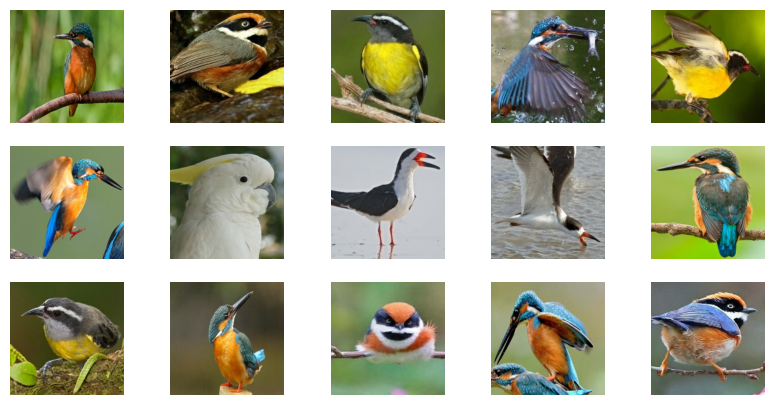

In [8]:
# 查看图片
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
# 读取一个batch的信息，输出图像和标签
for images, labels in train_dir.take(1):
    for i in range(15):
        # 设置子图排列为3*5
        ax = plt.subplot(3, 5, i + 1)  
        # 图片转为数组，用matplot读取  
        plt.imshow(images[i].numpy().astype("uint8"))        
        plt.axis("off")

In [9]:
# 查看图像和标签的信息
for image_batch, labels_batch in train_dir:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(15, 224, 224, 3)
(15, 5)


设置缓存，随机打乱数据

In [10]:
# 设置缓存，打乱数据
train_dir = train_dir.cache().shuffle(1000) # 通过缓存加快处理速度，随机打乱
val_dir = val_dir.cache() # 通过缓存加快处理速度

构建网络层，去掉网络结构最后一层<br>
平铺层设置多分类的激活函数

In [11]:
# 构建网络层
model = tf.keras.models.Sequential() # 搭建神经网络顺序模型
# 使用ResNet50模型
model.add(tf.keras.applications.ResNet50(include_top = False, # 网络结构的最后一层,resnet50有1000类,移除最后一层
                                        input_shape=(224,224,3), # 设置输入图像大小
                                        pooling = 'avg', # resnet50模型倒数第二层的输出是三维矩阵-卷积层的输出,做pooling或展平
                                        weights = 'imagenet'),# 参数有两种imagenet和None,None为从头开始训练,imagenet为从网络下载已训练好的模型开始训练
                                         )
model.add(layers.Flatten()) # 平铺层
model.add(tf.keras.layers.Dense(5, activation = 'softmax')) # 设置合适激活函数进行5分类

设置学习率适当学习率，<br>
设置损失函数为多分类交叉熵损失函数

In [12]:
# 设置优化器和学习率
optimizers = tf.keras.optimizers.Adam(learning_rate=1e-5)
# 编译（配置）模型
model.compile(optimizer=optimizers,  # 设置优化器
              loss='categorical_crossentropy', # 设置损失函数为交叉熵损失函数，适用于多分类任务
              metrics=['accuracy']) # 评价指标设置为准确率

In [13]:
# 训练模型
epochs = 10
import time
begin = time.time() # 开始时间
# 训练模型
history = model.fit(
    train_dir, # 训练集
    validation_data=val_dir, # 验证集
    epochs=epochs
)
end = time.time() # 结束时间
minute = (end-begin)/60
print("minute:",minute)

Epoch 1/10
37/37 [==============================] - 152s 4s/step - loss: 1.1998 - accuracy: 0.5493 - val_loss: 0.6110 - val_accuracy: 0.8162
Epoch 2/10
37/37 [==============================] - 145s 4s/step - loss: 0.2858 - accuracy: 0.9799 - val_loss: 0.2737 - val_accuracy: 0.9559
Epoch 3/10
37/37 [==============================] - 144s 4s/step - loss: 0.1200 - accuracy: 1.0000 - val_loss: 0.1804 - val_accuracy: 0.9853
Epoch 4/10
37/37 [==============================] - 147s 4s/step - loss: 0.0688 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9926
Epoch 5/10
37/37 [==============================] - 147s 4s/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 0.9926
Epoch 6/10
37/37 [==============================] - 148s 4s/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.1023 - val_accuracy: 0.9926
Epoch 7/10
37/37 [==============================] - 147s 4s/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0920 - val_accuracy: 0.9926
Epoch 8/10
37

记录准确率和损失值

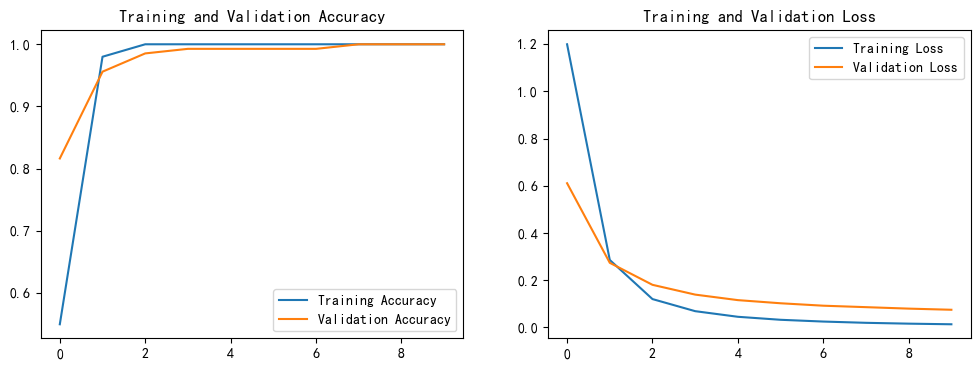

In [14]:
acc = history.history['accuracy'] # 训练集准确率
val_acc = history.history['val_accuracy'] # 验证集准确率率

loss = history.history['loss'] # 训练集损失
val_loss = history.history['val_loss'] # 验证集损失

epochs_range = range(epochs)# epochs

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) # 设置子图为1行两列，此为第一个
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # 设置子图为1行两列，此为第二个
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

保存模型、加载模型

In [15]:
# 保存模型
model.save('my_model.h5')

/root/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [16]:
from tensorflow.keras.models import load_model
# 加载模型
read_model=load_model('my_model.h5')

扩充维度<br>
预测

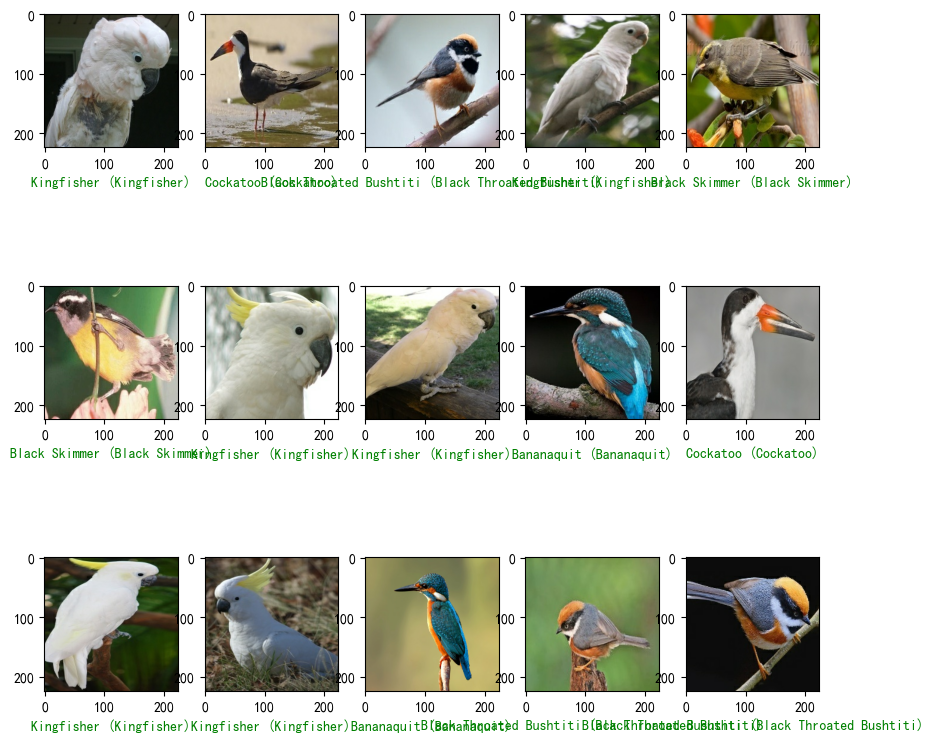

In [17]:
# 采用加载的模型来看预测结果

plt.figure(figsize=(10, 10))  # 图形的宽为10高为5
# 用训练好的模型对验证集进行预测
for images, labels in val_dir.take(1): # 取一个batch的图片和标签
    for i in range(15): # batch设置的是多少，这里即为多少
        plt.subplot(3, 5, i + 1) # 根据batch设置多个子图的个数及位置
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary) # 图像转为数组形式，用matplot读取
        img_array = tf.expand_dims(images[i], 0) # 对于单张图片，要符合训练集训练时的格式，即增加一个维度
        predictions = read_model.predict(img_array) # 对图片进行预测
        predicted_label = names[np.argmax(predictions)] # 预测值是5个概率，选取概率最大的，返回其索引，在names中通过此索引找出类别名称
        true_label = names[np.argmax(labels[i])] # 真实标签同理
        
        if predicted_label == true_label:
            color = 'green'
        else:
            color = 'red'
        #前面是预测分类，括号内是实际分类
        plt.xlabel("{} ({})".format(predicted_label,true_label),color=color)


plt.show()


预测

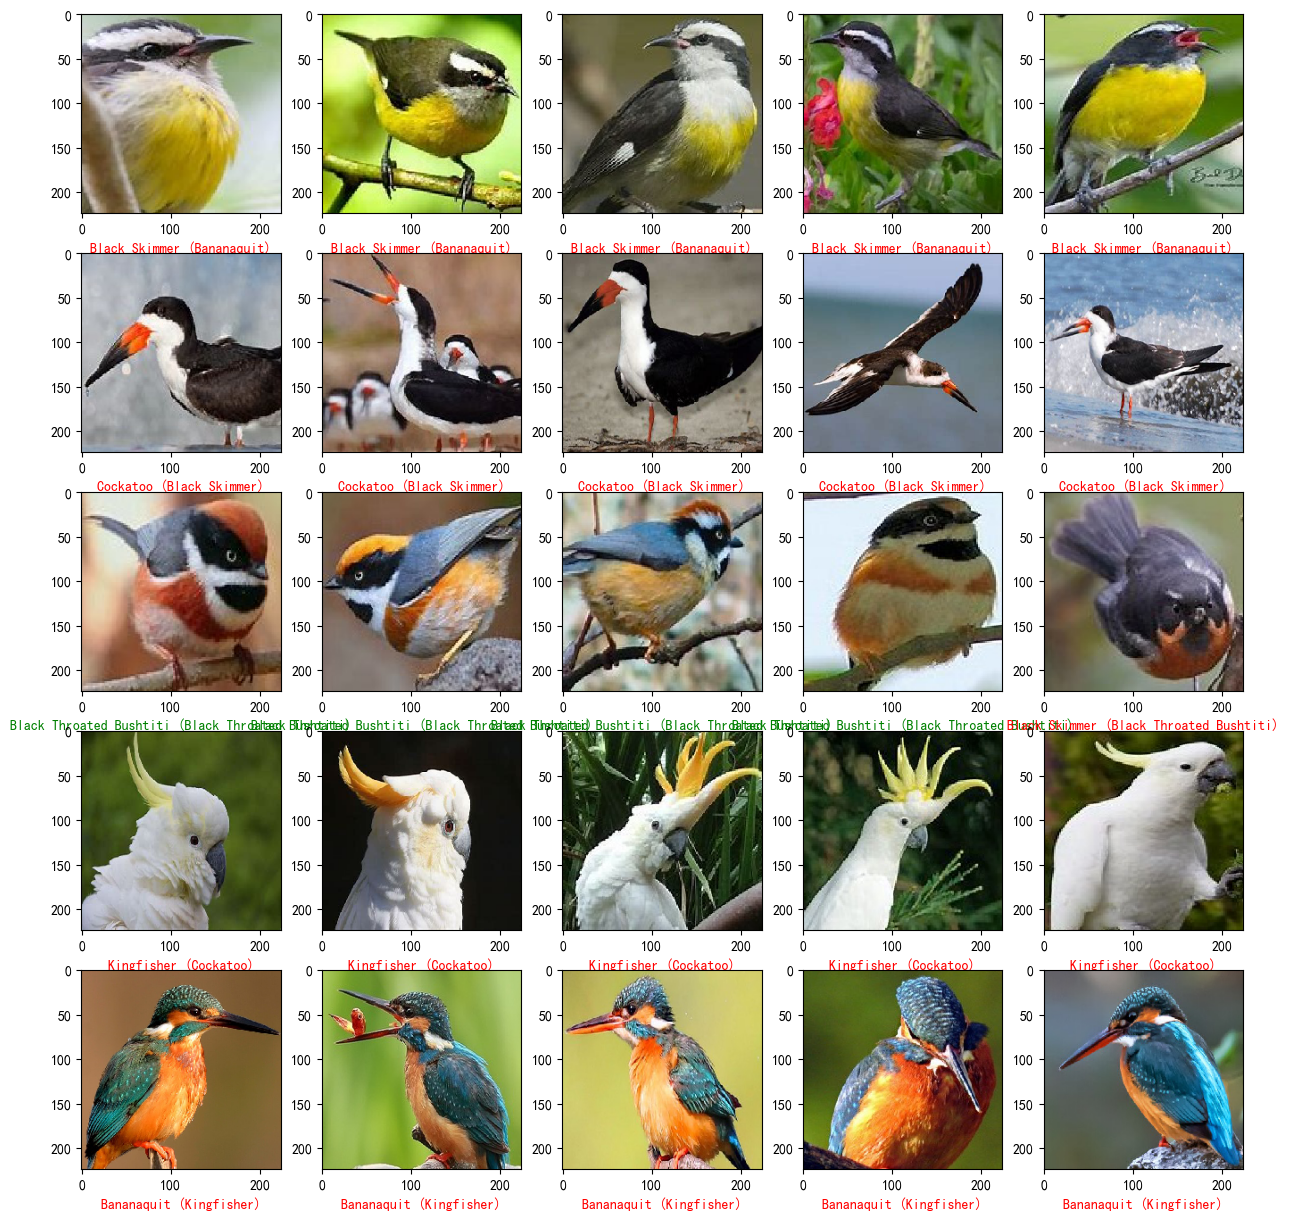

In [18]:
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image

paths = './images'
plt.figure(figsize=(15, 15)) #设置图像大小
for i,dirs in enumerate(os.listdir(paths)): # 遍历路径，或得图片“索引”及路径
    plt.subplot(5, 5, i + 1) # 总共25张图片，设置度子图为5*5
    image_path = paths+'/'+dirs  # 拼接路径
    img = image.load_img(image_path, target_size=(224, 224)) # 加载图片文件
    plt.imshow(img) # 展示图像
    x = image.img_to_array(img) # 图片转化为数组
    x = np.expand_dims(x, axis=0) # 对于单张图片，要符合训练集训练时的格式，即增加一个维度
    
    predictions = read_model.predict(x) # 预测
    predicted_label = names[np.argmax(predictions)] # 选取预测概率最大的

    dirs_cut = dirs[:-5] # 对名称进行切分，只保留类别名称
    # 预测标签是否等于真实标签，相同是绿色，不同是红色
    if predicted_label == dirs_cut:
        color = 'green'
    else:
        color = 'red'
    #前面是预测分类，括号内是实际分类
    plt.xlabel("{} ({})".format(predicted_label,
                                dirs_cut),color=color)    
plt.show()